In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
max_features = 15
n_points = 640
nu = np.linspace(0,1,n_points)
def random_chi3():
    """
    generates a random spectrum, without NRB. 
    output:
        params =  matrix of parameters. each row corresponds to the [amplitude, resonance, linewidth] of each generated feature (n_lor,3)
    """
    n_lor = np.random.randint(1,max_features)
    a = np.random.uniform(0,1,n_lor)
    w = np.random.uniform(0,1,n_lor)
    g = np.random.uniform(0.001,0.008, n_lor)
    # sorting the matrix by w
    params = np.c_[a,w,g]
    sorted_params = params[np.argsort(params[:, 1])]
    return sorted_params

print(random_chi3())
print(random_chi3().shape)

[[0.70192833 0.11903976 0.00311141]
 [0.39317561 0.12260154 0.00515592]
 [0.5417342  0.13248887 0.00340015]
 [0.92374225 0.14128736 0.00426634]
 [0.7166377  0.17426868 0.00630005]
 [0.56853521 0.216908   0.00448193]
 [0.10283457 0.24057854 0.00746473]
 [0.96934097 0.28470272 0.0034789 ]
 [0.05528163 0.28581568 0.00130971]
 [0.8709051  0.30981958 0.00420699]
 [0.24203994 0.40327641 0.00410492]
 [0.85939098 0.67205341 0.00735515]
 [0.1127675  0.83275449 0.00709257]]
(11, 3)


In [3]:
def build_chi3(params):
    """
    buiilds the normalized chi3 complex vector
    inputs: 
        params: (n_lor, 3)
    outputs
        chi3: complex, (n_points, )
    """
    
    chi3 = np.sum(params[:,0]/(-nu[:,np.newaxis]+params[:,1]-1j*params[:,2]),axis = 1)
    
    return chi3/np.max(np.abs(chi3))  
build_chi3(random_chi3()).shape

(640,)

In [4]:
def sigmoid(x,c,b):
	return 1/(1+np.exp(-(x-c)*b))

In [5]:
def generate_nrb():
    """
    Produces a normalized shape for the NRB
    outputs
        NRB: (n_points,)
    """
    bs = np.random.normal(10,5,2)
    c1 = np.random.normal(0.2,0.3)
    c2 = np.random.normal(0.7,.3)
    cs = np.r_[c1,c2]
    sig1 = sigmoid(nu, cs[0], bs[0])
    sig2 = sigmoid(nu, cs[1], -bs[1])
    nrb  = sig1*sig2
    return nrb

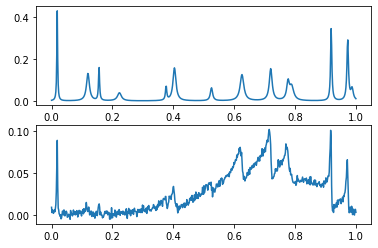

In [6]:
def get_spectrum():
    """
    Produces a cars spectrum.
    It outputs the normalized cars and the corresponding imaginary part.
    Outputs
        cars: (n_points,)
        chi3.imag: (n_points,)
    """
    rdchi_3=random_chi3()
    chi3 = build_chi3(rdchi_3)*np.random.uniform(0.3,1)
    nrb = generate_nrb()
    noise = np.random.randn(n_points)*np.random.uniform(0.0005,0.003)
    cars = ((np.abs(chi3+nrb)**2)/2+noise) 
    return cars, chi3.imag 
k=get_spectrum()
f, a= plt.subplots(2,1)
a[0].plot(nu,k[1])
a[1].plot(nu,k[0])
plt.show()


In [17]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Activation, Dropout, LSTM, Input
from keras import regularizers
from datetime import datetime
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True
callback=myCallback()

In [8]:
def generate_batch(size = 30):
    X = np.empty((size,n_points))
    y = np.empty((size,n_points))
    # z=np.empty((size, n_points,1))
    # X, y = get_spectrum()
    for i in range(size):
        X[i,:], y[i,:] = get_spectrum()
    return X, y
generate_batch()[0].shape

(30, 640)

In [25]:
data_train= generate_batch(4000)
x_train= data_train[0]
y_train=data_train[1]
# scaler= MinMaxScaler((0,1))
# x_train_scalled=scaler.fit_transform(x_train)
# y_train_scalled=scaler.fit_transform(y_train)
# x_train_scalled[0:5,0]
y_train.shape, x_train.shape

((4000, 640), (4000, 640))

In [59]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(x_train.shape[1], 1))
conv1 = Conv1D(filters=64,
               kernel_size=32,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2= Conv1D(filters=32, kernel_size=16, activation='relu', padding='same')(conv1)
lstm1 = LSTM(32, return_sequences=True)(conv2)
lstm2=LSTM(32,return_sequences=True)(lstm1)
output_layer = Dense(1)(lstm2)
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 640, 64)           2112      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 32)           32800     
_________________________________________________________________
lstm (LSTM)                  (None, 640, 32)           8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 32)           8320      
_________________________________________________________________
dense (Dense)                (None, 640, 1)            33        
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
__________________________________________________

In [60]:
model.compile(optimizer='adam', loss= 'mse', metrics='accuracy')

In [61]:
model.fit(x_train, y_train, epochs=50, batch_size=256, verbose=1, validation_split=0.2)

Epoch 1/50
13/13 [==============================] - 4s 277ms/step - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 3s 197ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 3/50
13/13 [==============================] - 3s 197ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 4/50
13/13 [==============================] - 3s 199ms/step - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/50
13/13 [==============================] - 3s 200ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 6/50
13/13 [==============================] - 3s 199ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/50
13/13 [==============================] - 3s 200ms/step - loss: 0.0012 - accuracy: 0.0000e

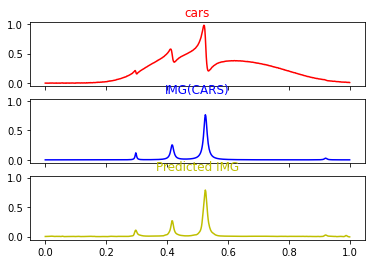

In [86]:
data_test= generate_batch(1)
x_test, y_test=data_test[0], data_test[1]
y_pred= model.predict(x_test)

f, ax=plt.subplots(3,1, sharex=True, sharey=True)
ax[0].plot(nu,x_test[0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(nu,y_test[0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(nu,y_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
plt.show()

In [85]:
rmse=tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
rmse(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.009647201>